In [1]:
from load_dataset import load_data
import utils
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd

## Instancier le jeu de données

In [2]:
X, y, cat_features = load_data().get_data_X_y(data='simplify')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Classification avec CatBoost

In [4]:
cat_clf = CatBoostClassifier(cat_features=cat_features, verbose=0, random_state=42)
cat_clf.fit(X_train, y_train)

print(f"Train Accuracy : {cat_clf.score(X_train, y_train) * 100:.3f} %")

Train Accuracy : 95.081 %


In [5]:
print(f"Test Accuracy : {cat_clf.score(X_test, y_test) * 100:.3f} %")

Test Accuracy : 91.460 %


In [6]:
preds = cat_clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       414
           1       0.91      0.96      0.93       675

    accuracy                           0.91      1089
   macro avg       0.92      0.90      0.91      1089
weighted avg       0.92      0.91      0.91      1089



In [19]:
from sklearn.metrics import f1_score

f1_score(y_test, cat_clf.predict(X_test), average='binary')

0.9332376166547021

In [7]:
# Validation croisée sur les données d'entraînement
cross_val = cross_val_score(cat_clf, X_train, y_train, cv=5)
cross_val

array([0.91748527, 0.90748031, 0.91338583, 0.91338583, 0.8976378 ])

In [8]:
print(f"Mean Cross-validation score sur le train dataset : {cross_val.mean() * 100:.3f}%")

Mean Cross-validation score sur le train dataset : 90.988%


## Feature Importance

In [9]:
utils.features_importance(cat_clf, X_train.columns, plot=False)

,Importance
Unités curriculaires 2e semestre (approuvées),26.658739
Frais de scolarité à jour,8.582287
Cours,7.757754
Unités curriculaires 1er semestre (approuvées),4.715053
Unités curriculaires 1er semestre (inscrits),4.402596
Unités curriculaires 2e semestre (inscrits),4.399074
Unités curriculaires 2e semestre (note),4.226874
Bourse,3.356458
Occupation père,3.210998
Qualification père,3.177676


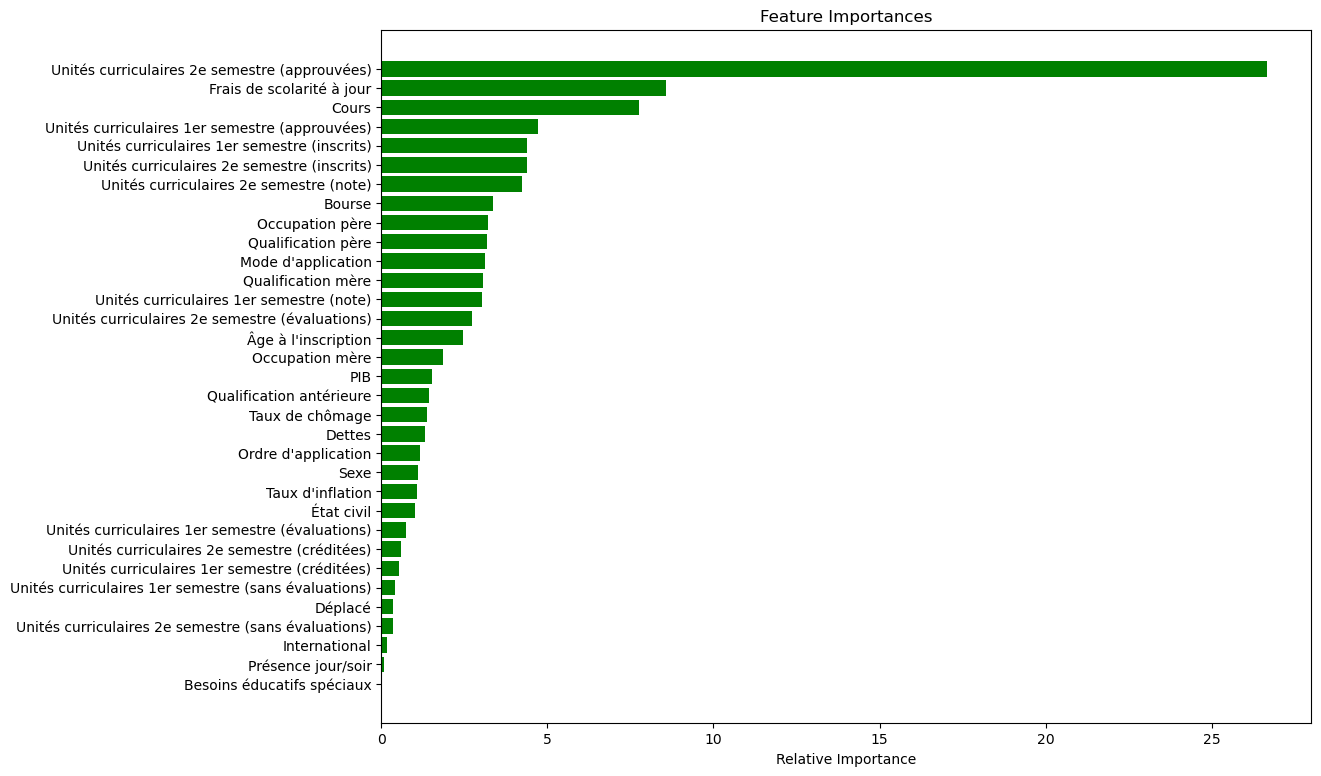

In [10]:
utils.features_importance(cat_clf, X_train.columns, plot=True)

### À voir si il y a de l'optimisation d'hyperparamètre à faire...

In [11]:
# Define the parameter grid to search
param_grid = {
    'iterations': [1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 9],
    'l2_leaf_reg': [1, 3, 5],
    'one_hot_max_size': [2, 150]
}

# Create a CatBoostClassifier
catboost_model = CatBoostClassifier(cat_features=cat_features, verbose=0, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='f1',  # Use an appropriate scoring metric
    cv=3,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPUs
    verbose=3,  # Set to 1 or higher for verbosity
)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best F1: ", grid_search.best_score_)

model = grid_search.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[CV 2/3] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.01, one_hot_max_size=150;, score=0.933 total time=   3.2s
[CV 1/3] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.01, one_hot_max_size=150;, score=0.923 total time=   3.3s
[CV 3/3] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.01, one_hot_max_size=150;, score=0.919 total time=   3.4s
[CV 1/3] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, one_hot_max_size=150;, score=0.918 total time=   2.7s
[CV 2/3] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, one_hot_max_size=150;, score=0.926 total time=   2.7s
[CV 3/3] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, one_hot_max_size=150;, score=0.917 total time=   2.9s
[CV 1/3] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.01, one_hot_max_size=2;, score=0.926 total time=  11.2s
[CV 2/3] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.01, one_hot_max_size=2;, score=0.935

In [12]:
model.fit(X_train, y_train)
print(f"Train Accuracy : {model.score(X_train, y_train) * 100:.3f} %")

Train Accuracy : 95.277 %


In [13]:
print(f"Test Accuracy : {model.score(X_test, y_test) * 100:.3f} %")

Test Accuracy : 91.368 %


In [16]:
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       414
           1       0.90      0.97      0.93       675

    accuracy                           0.91      1089
   macro avg       0.92      0.90      0.91      1089
weighted avg       0.92      0.91      0.91      1089



In [18]:
from sklearn.metrics import f1_score

f1_score(y_test, model.predict(X_test), average='binary')

0.9329529243937233